In [2]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
%matplotlib inline

In [15]:
tree = ET.parse("../Population/plans.xml")
root = tree.getroot()

In [16]:
atts = ["ids", "gender", "age", "education", "work", "nationality", "residence", "section"]
ts = {"activity":"type", "leg":"mode"}

relations = {k:{} for k in atts}

for e in root.findall("person"):

    m = {k:v for k,v in zip(atts,e.get("id").split("__"))}

    t = {a2:[a.get(a2) for a in e.find("plan").findall(a1)] for a1,a2 in ts.items()}

    for t_name, t_var in t.items():
        for t_val in t_var:
            for name, var in m.items():
                if var not in relations[name]:
                    relations[name][var] = {k:{} for k in t.keys()}

                relations[name][var][t_name][t_val] = relations[name][var][t_name].get(t_val,0)+1

In [17]:
rows = []

for attr_name, attr_vals in relations.items():
    for attr_val, data in attr_vals.items():
        for kind, counts in data.items():
            for label, count in counts.items():
                rows.append({
                    "attribute": attr_name,
                    "value": attr_val,
                    "column": f"{kind}_{label}",
                    "count": count
                })

df_long = pd.DataFrame(rows)

In [18]:
df_big = (
    df_long
    .pivot_table(
        index=["attribute", "value"],
        columns="column",
        values="count",
        fill_value=0
    )
    .sort_index()
)
df_big.head()

column                    mode_  mode_Car  mode_PT  type_AroundTheBlock  \
attribute value                                                           
age       0_to_4_years      4.0    2829.0    245.0                 20.0   
          10_to_14_years    5.0    3205.0    284.0                 19.0   
          15_to_19_years    6.0    2828.0    793.0                 14.0   
          20_to_24_years    2.0    3434.0   1116.0                 13.0   
          25_to_29_years    8.0    4897.0    357.0                 38.0   

column                    type_Doctor  type_EatOut  type_Groceries  type_Home  \
attribute value                                                                 
age       0_to_4_years           55.0        126.0           172.0     1323.0   
          10_to_14_years         28.0         56.0           101.0     1452.0   
          15_to_19_years         15.0         79.0            77.0     1607.0   
          20_to_24_years         16.0        113.0            95.0     2014.0   
          25_to_29_years         35.0        124.0           194.0     2188.0   

column                    type_LeasureCollective  type_LeasureOther  \
attribute value                                                       
age       0_to_4_years                      45.0               38.0   
          10_to_14_years                    53.0               57.0   
          15_to_19_years                    34.0               56.0   
          20_to_24_years                    39.0               53.0   
          25_to_29_years                    36.0               82.0   

column                    type_LeasureSportOrCulural  type_Other  \
attribute value                                                    
age       0_to_4_years                          18.0        26.0   
          10_to_14_years                        30.0        33.0   
          15_to_19_years                        21.0        32.0   
          20_to_24_years                        29.0        37.0   
          25_to_29_years                        27.0        33.0   

column                    type_PersonalIssues  type_School  \
attribute value                                              
age       0_to_4_years                   52.0        149.0   
          10_to_14_years                 22.0        901.0   
          15_to_19_years                 26.0        956.0   
          20_to_24_years                 34.0       1264.0   
          25_to_29_years                 55.0        105.0   

column                    type_TakeSomeoneSomewhere  type_VisitFriendFamily  \
attribute value                                                               
age       0_to_4_years                        255.0                   129.0   
          10_to_14_years                      335.0                   149.0   
          15_to_19_years                      112.0                   125.0   
          20_to_24_years                      128.0                   161.0   
          25_to_29_years                      634.0                   168.0   

column                    type_Work  type_Workout  
attribute value                                    
age       0_to_4_years        607.0          63.0  
          10_to_14_years      157.0         101.0  
          15_to_19_years      385.0          88.0  
          20_to_24_years      422.0         134.0  
          25_to_29_years     1446.0          97.0

In [12]:
def plot_grid(df_big, attribute, prefix, title=None, log=False, normalize=True, save=None):
    df = df_big.loc[attribute]

    cols = [c for c in df.columns if c.startswith(prefix)]
    df = df[cols]

    if normalize:
        df = df.div(df.sum(axis=1), axis=0)

    df.columns = [c.replace(prefix, "") for c in df.columns]

    Z = df.values.T

    if log:
        Z = np.log1p(Z)

    fig, ax = plt.subplots(figsize=(0.6 * len(df), 0.4 * len(df.columns)))

    im = ax.imshow(Z, aspect="auto")

    ax.set_xticks(range(len(df.index)))
    ax.set_xticklabels(df.index, rotation=45, ha="right")

    ax.set_yticks(range(len(df.columns)))
    ax.set_yticklabels(df.columns)

    ax.set_xlabel(attribute)
    ax.set_ylabel(prefix.rstrip("_"))
    ax.set_title(title or f"{attribute} vs {prefix.rstrip('_')}")

    plt.colorbar(im, ax=ax, label="count")
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    else:
        plt.show()

/tmp/ipykernel_13885/786077682.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_13885/786077682.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_13885/786077682.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


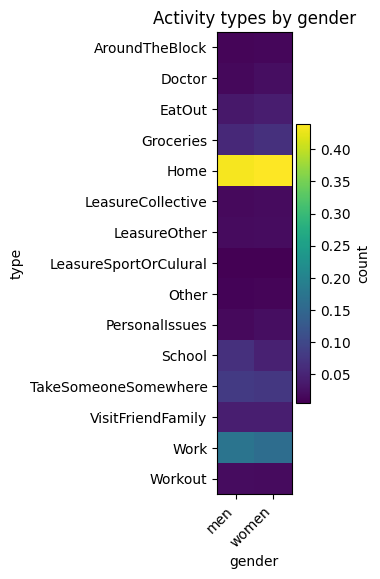

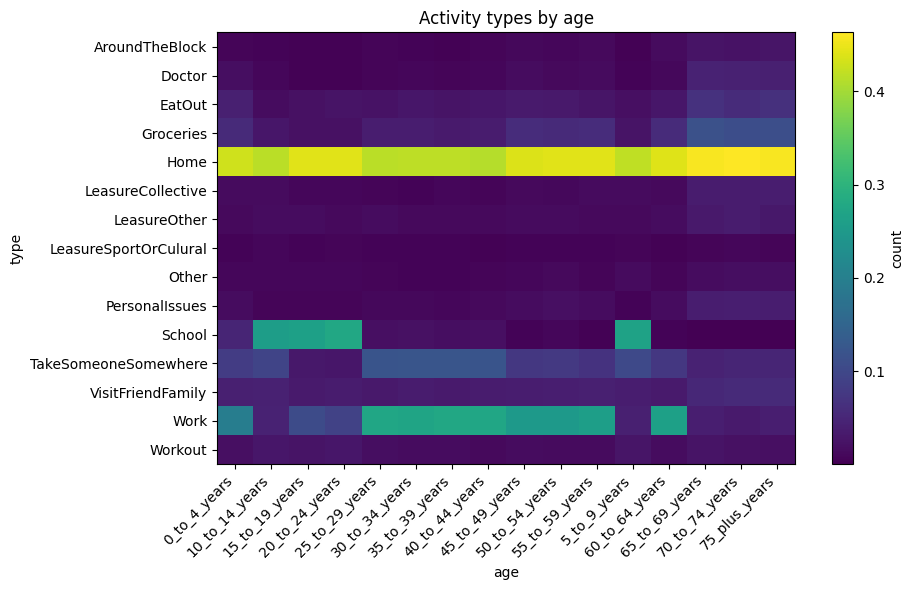

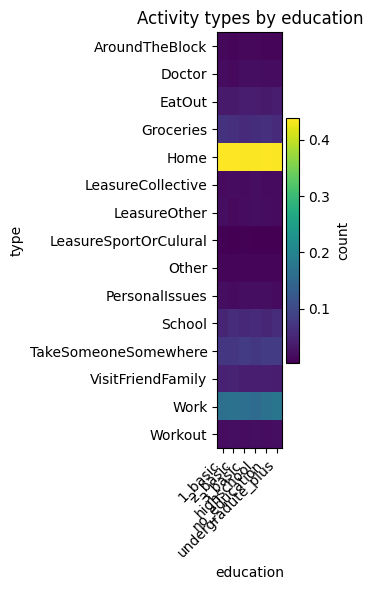

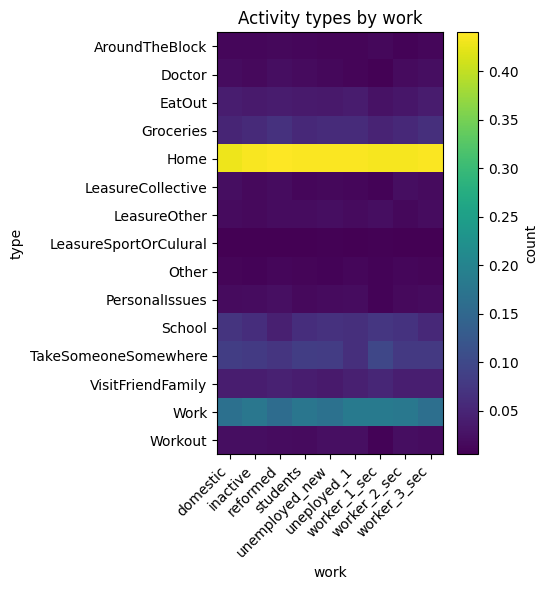

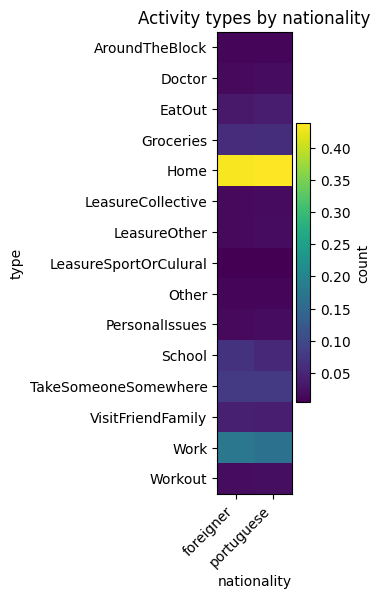

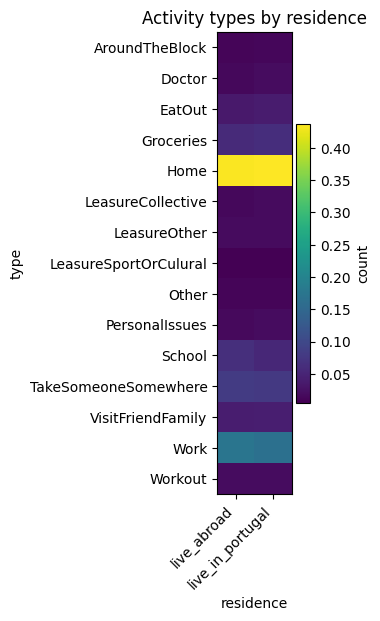

In [13]:
for att in atts[1:-1]:
    plot_grid(
        df_big,
        attribute=att,
        prefix="type_",
        title=f"Activity types by {att}",
        save=f"plots/{att}_type.png"
    )
